In [1]:
import rnn_tiles
from rnn_pixels import *
import rasterio
import keras
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import MaxPooling3D, Conv2D, MaxPooling2D, SeparableConv2D, ConvLSTM2D, TimeDistributed, UpSampling2D, Concatenate
from keras.layers import Activation, BatchNormalization
from keras.optimizers import SGD, Adadelta, Adam
from keras import Input
from keras import Model
import os
import sys
from sklearn.utils import class_weight
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import utilities as util
import importlib
import rnn_tiles
importlib.reload(rnn_tiles)

SyntaxError: invalid syntax (utilities.py, line 38)

In [2]:
def strangeBlock(input_block, nb_layers, filters):
    x_list = [input_block]
    c_temp = input_block
    for i in range(nb_layers):
        c_l = ConvLSTM2D(filters=filters,kernel_size=(3,3), activation='elu', padding = 'same', return_sequences=True) (c_temp)
        x_list.append(c_l)
        merge = Concatenate()(x_list)
        c_temp = merge
    return c_temp
    

In [3]:
def strange_network_v2(input_shape, class_count):
    input_img = Input(input_shape)
    strange_block_1 = strangeBlock(input_img, 4, 20)
    pool_1 = TimeDistributed(MaxPooling2D((3,3), padding='same')) (strange_block_1)
    strange_block_2 = strangeBlock(pool_1, 4, 20)
    upsample_1 = TimeDistributed(UpSampling2D((3,3))) (strange_block_2)
    conv_1 = TimeDistributed(Conv2D(32, (3,3)))(upsample_1)
    conv_lc = ConvLSTM2D(filters=class_count,kernel_size=(1,1), activation='softmax', padding = 'same', return_sequences=False, name='landcover') (conv_1)
    reshaping = Reshape((64*64,class_count)) (conv_lc)
    #conv_out_cc = ConvLSTM2D(filters=1,kernel_size=(1,1), padding = 'same', return_sequences=False, name='canopy')(conv_1)
    model = Model(inputs=input_img, outputs=reshaping)  # conv_out_cc])
    return model

In [4]:
lc_labels = rasterio.open('/deep_data/recurrent_data/NLCD_DATA/landcover/NLCD_2011_Land_Cover_L48_20190424.img')
canopy_labels = rasterio.open('/deep_data/recurrent_data/NLCD_DATA/canopy/CONUSCartographic_2_8_16/Cartographic/nlcd2011_usfs_conus_canopy_cartographic.img')

In [5]:
tiles = {}
landsat_datasets = {}
tiles['028012'] = ['20110324', '20110612', '20110831', '20111103']
tiles['029011'] = ['20110308', '20110425', '20110831', '20111103']
tiles['028011'] = ['20110308', '20110628', '20110831', '20111103']
for tile_number, dates in tiles.items():
    tile_datasets = []
    l8_image_paths = []
    for date in dates:
        l8_image_paths.append('/deep_data/recurrent_data/tile{}/combined/combined{}.tif'.format(tile_number, date))
    for fp in l8_image_paths:
        tile_datasets.append(rasterio.open(fp))
    landsat_datasets[tile_number] = tile_datasets

In [6]:
tile_size = 64
tile_list = ['028012', '029011', '028011']
class_count = 5

In [7]:
px = make_pixels(tile_size, tile_list)
pixels = delete_bad_tiles(landsat_datasets, px, tile_size)

In [8]:
len(pixels)

6143

In [9]:
w_tile_gen = rnn_tiles.rnn_tile_gen(landsat_datasets, lc_labels, canopy_labels, tile_size, class_count)

In [10]:
w_generator = w_tile_gen.tile_generator(pixels, batch_size=1)
total_labels = list()
count = 0
while count < len(px):
        image_b, label_b = next(w_generator)
        label_b = np.argmax(label_b, axis=-1)
        total_labels.append(label_b)
        count+=1
total_labels = np.asarray(total_labels)
total_labels = total_labels.reshape(len(total_labels)*64*64)
buckets = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0}
for label in total_labels:
    buckets[label] +=1
print(buckets)

{0: 31359659, 1: 294190, 2: 28908645, 3: 13081025, 4: 1116673, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0}


In [11]:
weights_list = class_weight.compute_class_weight('balanced', np.unique(total_labels), total_labels)

In [12]:
np.unique(total_labels)

array([0, 1, 2, 3, 4])

In [13]:
#weights_list = np.insert(weights_list, 1, 0)
weights_list[0] = weights_list[0]/10

In [14]:
weights = np.zeros((tile_size*tile_size, class_count))
for index in range(len(weights_list)):
    weights[:, index] = weights_list[index]

In [15]:
weights

array([[4.76792123e-02, 5.08244278e+01, 5.17216853e-01, 1.14303263e+00,
        1.33898092e+01],
       [4.76792123e-02, 5.08244278e+01, 5.17216853e-01, 1.14303263e+00,
        1.33898092e+01],
       [4.76792123e-02, 5.08244278e+01, 5.17216853e-01, 1.14303263e+00,
        1.33898092e+01],
       ...,
       [4.76792123e-02, 5.08244278e+01, 5.17216853e-01, 1.14303263e+00,
        1.33898092e+01],
       [4.76792123e-02, 5.08244278e+01, 5.17216853e-01, 1.14303263e+00,
        1.33898092e+01],
       [4.76792123e-02, 5.08244278e+01, 5.17216853e-01, 1.14303263e+00,
        1.33898092e+01]])

In [16]:
train_px, val_px, test_px = train_val_test_split(pixels, 0.7, 0.7)

train:4300 val:1290 test:941


In [17]:
epochs = 200
batch_size = 25

In [18]:
model = strange_network_v2((4, 64, 64, 7), class_count)

In [19]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 4, 64, 64, 7) 0                                            
__________________________________________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)     (None, 4, 64, 64, 20 19520       input_1[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 4, 64, 64, 27 0           input_1[0][0]                    
                                                                 conv_lst_m2d_1[0][0]             
__________________________________________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)     (None, 4, 64, 64, 20 33920       concatenate_1[0][0]              
__________

In [20]:
model = keras.utils.multi_gpu_model(model, 4)

In [21]:
random.shuffle(train_px)

In [36]:
importlib.reload(rnn_tiles)

<module 'rnn_tiles' from '/host/Desktop/cnn_dev/florence_mapping/rcnn/rnn_tiles.py'>

In [37]:
tile_gen = rnn_tiles.rnn_tile_gen(landsat_datasets, lc_labels, canopy_labels, tile_size, class_count)

In [31]:
from keras.optimizers import Adam

In [32]:
filepath ='weights.{epoch:02d}-{val_loss:.2f}_merged.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [33]:
callbacks_list = [checkpoint]

In [34]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [38]:
model.fit_generator(generator=tile_gen.tile_generator(train_px, batch_size), 
                    steps_per_epoch=len(train_px) // batch_size, epochs=epochs, verbose=1,
                    validation_data=tile_gen.tile_generator(val_px, batch_size),
                    validation_steps=len(val_px) // batch_size, class_weight=weights_list, callbacks=callbacks_list) 

Epoch 1/200
0
0
0
1
9
1072
237
1072
3
0
0
0
442
46
0
0
0
1072
0
0
1072
0
1072
1060
8
0
0
51
0
1072
461
0
1072
239
588
254
0
1072
1072
90
9
1072
0
1072
1072
1072
63
1072
1072
1039
1072
467
0
0
1066
0
1037
1072
3
263
1072
0
48
0
2
1072
0
1072
0
1072
47
0
0
1072
0
0
1072
1072
0
1072
0
1072
15
10720

9
1072
1072
0
0
661
9
0
21
0
0
1045
  1/172 [..............................] - ETA: 3:39 - loss: 8.6857e-08 - acc: 0.38351072
1051
0
51
1
1072
1072
1072
0
1072
0
1072
267
0
1072
0
1072
432
0
0
1072
472
47
1072
1072
0
1072
1072
1072
0
1057
0
1072
1072
0
246
1072
1068
0
7
0
0
15
1
1072
0
  2/172 [..............................] - ETA: 2:34 - loss: 8.7980e-08 - acc: 0.36820
1072
1072
1072
0
0
0
0
1072
1072
2
47
572
1072
9
0
0
7
0
0
1
0
1072
1072
1072
0
798
1072
1055
2
1072
4
0
0
1072
1072
22
1072
1072
1072
1072
1072
339
579
2
  3/172 [..............................] - ETA: 2:12 - loss: 8.2126e-08 - acc: 0.42870
1072
47
4
0
0
1072
1072
1
11
0
1072
0
0
1072
1072
1049
1072
35
1072
26
1072
88
0
0
2


KeyboardInterrupt: 

In [42]:
model.load_weights('weights.01-1.76.hdf5')

In [43]:
predictions = model.predict_generator(generator = tile_gen.tile_generator(test_px, batch_size=1), steps=len(test_px) // 1, verbose=1)
eval_generator = tile_gen.tile_generator(test_px, batch_size=1)


941/941 [==============================] - 63s 67ms/step


In [44]:
print(predictions.shape)

(941, 4096, 14)


In [45]:
pred = np.argmax(predictions,axis=-1)

In [46]:
labels = np.empty(pred.shape)
count = 0
while count < len(labels):
        image_b, label_b = next(eval_generator)
        label_b = np.argmax(label_b, axis=-1)
        labels[count] = label_b
        count += 1


In [47]:
label_index = labels.reshape(941*4096)
pred_index = pred.reshape(941*4096)

In [48]:
pred_index.shape

(3854336,)

Accuracy is 0.6149417175876727


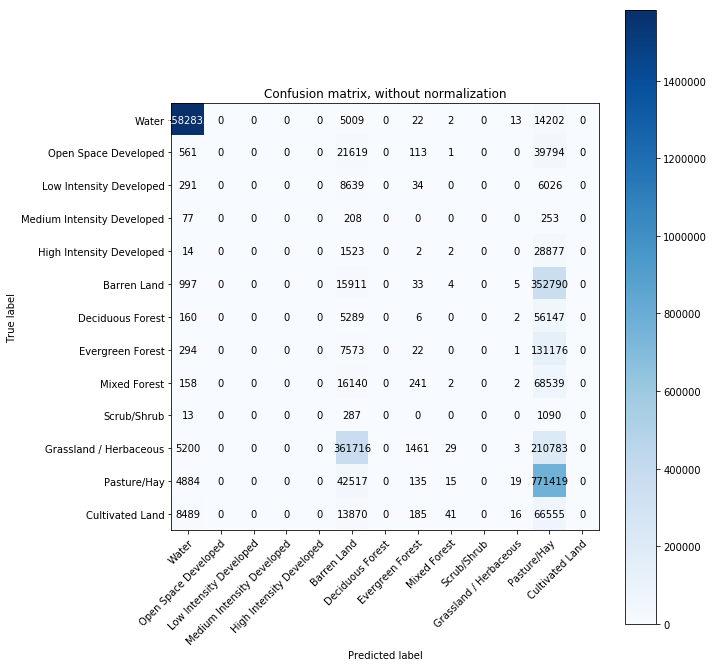

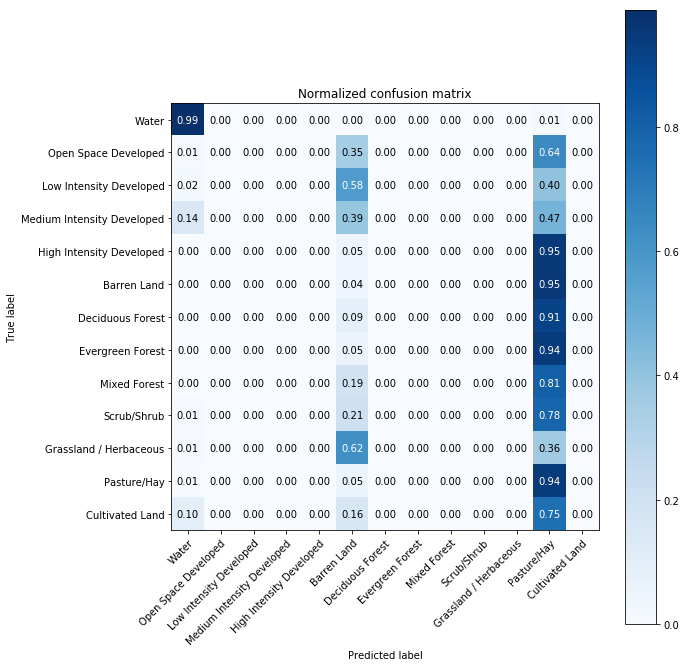

In [49]:
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
util.plot_confusion_matrix(label_index.astype(np.int), pred_index.astype(np.int), classes=np.array(list(util.indexed_dictionary)),
                      class_dict=util.indexed_dictionary)
# Plot normalized confusion matrix
util.plot_confusion_matrix(label_index.astype(np.int), pred_index.astype(np.int), classes=np.array(list(util.indexed_dictionary)),
                      class_dict=util.indexed_dictionary,
                      normalize=True)
count = 0
for i in range(len(label_index)):
    if(label_index[i] == pred_index[i]):
        count+=1
print("Accuracy is {}".format(count/len(label_index)))

In [69]:
from sklearn.utils.multiclass import unique_labels


In [70]:
unique_labels(label_index, pred_index)

array([ 0.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.])

In [ ]:
def jaccard_distance(y_true, y_pred, smooth=100):
    """Jaccard distance for semantic segmentation.
    Also known as the intersection-over-union loss.
    This loss is useful when you have unbalanced numbers of pixels within an image
    because it gives all classes equal weight. However, it is not the defacto
    standard for image segmentation.
    For example, assume you are trying to predict if
    each pixel is cat, dog, or background.
    You have 80% background pixels, 10% dog, and 10% cat.
    If the model predicts 100% background
    should it be be 80% right (as with categorical cross entropy)
    or 30% (with this loss)?
    The loss has been modified to have a smooth gradient as it converges on zero.
    This has been shifted so it converges on 0 and is smoothed to avoid exploding
    or disappearing gradient.
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    # Arguments
        y_true: The ground truth tensor.
        y_pred: The predicted tensor
        smooth: Smoothing factor. Default is 100.
    # Returns
        The Jaccard distance between the two tensors.
    # References
        - [What is a good evaluation measure for semantic segmentation?](
           http://www.bmva.org/bmvc/2013/Papers/paper0032/paper0032.pdf)
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

In [ ]:
def strange_network(input_shape):
    input_img = Input(input_shape)
    #c_l1 = ConvLSTM2D(filters=32,kernel_size=(2,2), activation='elu', padding = 'same', return_sequences=True) (input_img)
    #c_l2 = ConvLSTM2D(filters=32,kernel_size=(2,2), activation='elu', padding = 'same', return_sequences=True) (c_l1)
    c_l3 = ConvLSTM2D(filters=32,kernel_size=(2,2), activation='elu', padding = 'same', return_sequences=True) (input_img)
    #pool_1 = TimeDistributed(MaxPooling2D((3,3), padding='same')) (c_l3)
    #c_l4 = ConvLSTM2D(filters=32,kernel_size=(2,2), activation='elu', padding = 'same', return_sequences=True) (pool_1)
    #c_l5 = ConvLSTM2D(filters=32,kernel_size=(2,2), activation='elu', padding = 'same', return_sequences=True) (c_l4)
    #c_l6 = ConvLSTM2D(filters=32,kernel_size=(2,2), activation='elu', padding = 'same', return_sequences=True) (pool_1)
    #upsample_1 = TimeDistributed(UpSampling2D((3,3))) (c_l6)
    conv_1 = TimeDistributed(Conv2D(32, (3,3), padding='same'))(c_l3)
    #merge = Concatenate()([c_l3, conv_1])
    conv_lc = ConvLSTM2D(filters=16,kernel_size=(1,1), activation='softmax', padding = 'same', return_sequences=False) (conv_1)
    #conv_out_cc = ConvLSTM2D(filters=1,kernel_size=(1,1), activation='sigmoid', padding = 'same', return_sequences=False)(merge)
    #model = Model(inputs=input_img, outputs=[conv_lc, conv_out_cc])
    model = Model(inputs=input_img, outputs=conv_lc)
    return model

    
